# Library

In [1]:
import os
import math
import dill
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squigglepy as sq

from squigglepy import bayes
from squigglepy.numbers import K, M, B, T
from copy import deepcopy
from scipy import stats
from pprint import pprint
from collections import Counter
from tqdm import tqdm
from datetime import datetime as dt, timedelta

%matplotlib inline
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

print('Using squiggle version {}'.format(sq.__version__))

Loaded 1
Loaded 2
Using squiggle version 0.29-dev3


In [2]:
VARS = {}

# Global variables - probably don't want to change these but you could.
VARS['RUNS'] = 100_000                                  # Number of runs to do (default 100*K)
VARS['CURRENT_YEAR'] = 2025                             # What year to start the run on? (default: 2025)
VARS['MAX_YEAR'] = VARS['CURRENT_YEAR'] + 100           # What year to end the run on? (default: 2125)

CURRENT_YEAR = VARS['CURRENT_YEAR']
years = range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR'])
print('Loaded')


Loaded


# Model

### TAI Scenarios

In [3]:
# Conditional on making agentic TAI, will it be aligned by default? Or will it otherwise fail to be power-seeking in a relevant way?
VARS['p_tai_alignment_is_easy'] = 0.15
VARS['p_tai_not_powerseeking'] = 0.1
VARS['p_tai_aligned_by_default'] = VARS['p_tai_alignment_is_easy'] + ((1 - VARS['p_tai_alignment_is_easy']) * VARS['p_tai_not_powerseeking'])


# Conditional on making agentic TAI that is not aligned by default, will we solve the alignment problem?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_solved(year, first_attempt=True, verbose=False):
    if first_attempt:
        p = min(1.9 * (year/45), 0.8)
    else:
        p = min(2.5 * (year/45), 0.9)
    if verbose == 2:
        print('* alignment solve diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
VARS['p_alignment_solved'] = p_alignment_solved
# TODO: Convert to logistic curves


# Conditional on making agentic TAI that is not aligned by default, will we successfully coordinate to deploy safe AI?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_deployment_safety_and_coordination(year, war, variables, first_attempt=True, verbose=False):
    if year <= 2030 - variables['CURRENT_YEAR']:
        p = 0.7 if war else 0.85
    else:
        p = 0.4 if war else 0.6
    if first_attempt is False:
        p += 0.1
    p = min(p, 0.95)
    p = max(p, 0.05)
    if verbose == 2:
        print('* alignment coordination diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
VARS['p_alignment_deploy_coordination'] = p_alignment_deployment_safety_and_coordination

# Conditional on solving the alignment problem, what is the chance we also solve the subtle misalignment problem?
VARS['p_subtle_alignment_solved'] = 0.85

# Conditional on alignment by default, what is the chance we also solve the subtle misalignment problem?
VARS['p_subtle_alignment_solved_if_aligned_by_default'] = 0.3

# Conditional on having aligned AI, will we know it is aligned and therefore want to deploy it?
VARS['p_know_aligned_ai_is_aligned'] = 0.7

# Conditional on having misaligned AI, will we know it is misaligned and therefore not want to deploy it?
VARS['p_know_misaligned_ai_is_misaligned'] = 0.8

# Conditional on having agentic TAI, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 if war else 0.05
VARS['p_tai_intentional_misuse'] = p_tai_intentional_misuse

# If TAI is fully misaligned and deployed what is the chance we can successfully detect and avert this?
VARS['p_full_tai_misalignment_averted'] = 0.2

# If TAI is fully misaligned but successfully averted, what is the probability there will still be a catasrophe (10%+ death) in the process of averting it?
VARS['p_tai_misalignment_averting_is_catastrophic'] = 0.3

# If TAI is fully misaligned and we successfully avert it, what is the chance we give up on TAI?
VARS['p_full_tai_misalignment_averted_means_abandoned_tai'] = 0.4

# If TAI is fully misaligned, what is the chance it results in extinction versus a singleton?
VARS['p_tai_xrisk_is_extinction'] = 0.1

# If there is a fully misaligned TAI singleton, what is the chance it results in a non-extinction catastrophe (10%+ death)?
VARS['p_tai_singleton_is_catastrophic'] = 0.8

# If ther is an intentional attempt to misuse TAI to create a singleton, what is the chance it causes extinction instead?
VARS['p_intentional_tai_singleton_creates_extinction'] = 0.05


exec(open('modules/tai_risk.py').read())
print('Loaded TAI scenarios module')


Loaded TAI scenarios module


In [4]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))
VARS['delay'] = delay
print('Loaded')
delay

Cache from: 2025-01-23 12:52:18.919869
Loaded


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev3)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49) (version 0.28-dev3)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49) (version 0.28-dev3)}}

### Nuclear Scenarios Module

In [5]:
# Annual chance Russia uses a nuke
def p_russia_uses_nuke(peace, year, variables):
    peace = 10 if peace else 1
    year = year + variables['CURRENT_YEAR']
    if year == 2025:
        return 0.03
    else:
        return 0.001 / peace
VARS['p_russia_uses_nuke'] = p_russia_uses_nuke


# Annual chance North Korea uses a nuke
VARS['p_nk_uses_nuke'] = 0.001


# Annual chance China uses a nuke
def p_china_uses_nuke(peace, year, variables):
    return VARS['p_china_invades_taiwan'](peace, year, variables) * 0.01
VARS['p_china_uses_nuke'] = p_china_uses_nuke

    
# Annual chance another country uses a nuke
def p_other_uses_nuke(peace):
    peace = 10 if peace else 1
    return 0.0002 / peace
VARS['p_other_uses_nuke'] = p_other_uses_nuke


# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.05 if war else 0.02
    p = p * (0.998 ** year)
    return p
VARS['p_nuclear_accident'] = p_nuclear_accident


# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.2 if war else 0.05
VARS['p_nuclear_accident_becomes_exchange'] = p_nuclear_accident_becomes_exchange


# Conditional on a nuclear exchange, what is the chance it escalates into a catastrophe (10%+ dead)?
def p_catastrophe_from_nuclear_exchange(war):
    p_exchange_becomes_all_out_war = 0.6 if war else 0.3
    p_nuclear_winter_happens = 0.4 # Also something about ozone?
    alternative_foods_or_other_save = 0.1
    return (p_exchange_becomes_all_out_war *
            (p_nuclear_winter_happens + (1 - p_nuclear_winter_happens) * 0.1) *
            (1 - alternative_foods_or_other_save))
VARS['p_catastrophe_from_nuclear_exchange'] = p_catastrophe_from_nuclear_exchange

    
# Conditional on a nuclear exchange catastrophe, what is the chance it becomes an xrisk?
VARS['p_xrisk_from_nuclear_catastrophe'] = 0.05 # https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would


# Conditional on a great power war, what is the chance it goes intentionally nuclear in any given year?
def p_nuclear_exchange_given_war(first_year_of_war):
    return 0.1 if first_year_of_war else 0.02
VARS['p_nuclear_exchange_given_war'] = p_nuclear_exchange_given_war


exec(open('modules/nuclear.py').read())
print('Loaded nuclear scenarios module')


Loaded nuclear scenarios module


### China Scenarios Module

In [6]:
# Will China launch a full-scale invasion of Taiwan by the following years?
# https://www.metaculus.com/questions/11480/china-launches-invasion-of-taiwan/
p__china_invade_before_2025 = 0.01
p__china_invade_before_2030 = 0.3
p__china_invade_before_2035 = 0.4
print('p(11480 - China invade Taiwan before 2035) = {}%'.format(round(p__china_invade_before_2035 * 100, 1)))


# Will China engage in a full-scale blockade against Taiwan before the following years?
# https://www.metaculus.com/questions/12309/china-engages-in-a-blockade-against-taiwan/
p__china_blockade_before_2025 = 0.05
p__china_blockade_before_2030 = 0.5
p__china_blockade_before_2035 = 0.6
print('p(12309 - China blockade Taiwan before 2035) = {}%'.format(round(p__china_blockade_before_2035 * 100, 1)))


# If China invades Taiwan before 2035, will the US respond with military force?
# https://www.metaculus.com/questions/11112/us-response-if-china-invades-taiwan-2035/
p__us_protects_voluntarily = 0.3
p__china_preemptive_attack = 0.4
p__us_defends_japan = 0.5

p__us_defends = (p__china_preemptive_attack +
                (1 - p__china_preemptive_attack) * p__us_protects_voluntarily +
                (1 - p__china_preemptive_attack) * (1 - p__us_protects_voluntarily) * p__us_defends_japan)
print('p(11112 - US defends conditional) = {}%'.format(round(p__us_defends * 100, 1)))


# If there are 100 deaths in conflict between China and Taiwan before 2050, will Taiwan receive direct military support from allied nations?
# https://www.metaculus.com/questions/7812/taiwan-to-receive-support-in-china-conflict/
print('p(7812 - Anyone defends conditional) = {}%'.format(round((p__us_defends + (1 - p__us_defends) * 0.6 * 0.3) * 100, 1)))


# Will the People's Republic of China annex at least half of Taiwan before 2050?
# https://www.metaculus.com/questions/5320/chinese-annexation-of-half-of-taiwan-by-2050/
p__china_half_of_taiwan = p__china_invade_before_2035 * (0.7 * (1 - p__us_defends) + 0.4 * p__us_defends)
print('p(5320 - China half of Taiwan) = {}%'.format(round(p__china_half_of_taiwan * 100, 1)))


# Will there be a US-China war before 2035?
# https://www.metaculus.com/questions/8362/us-china-war-before-2035/
p__us_china_war = (p__china_invade_before_2035 * p__us_defends +
                  (1 - p__china_invade_before_2035) * (p__china_blockade_before_2035) * p__us_defends * 0.7 * 0.25)
print('p(8362 - US-China war) = {}%'.format(round(p__us_china_war * 100, 1)))


# Will Taiwan/Republic of China declare independence by 2035?
# https://www.metaculus.com/questions/12795/taiwan-declares-independence-by-2035/
p__taiwan_independence = (p__china_invade_before_2035 * 0.9 +
                         (1 - p__china_invade_before_2035) * (p__china_blockade_before_2035) * 0.8 * 0.25 +
                         (1 - p__china_invade_before_2035) * (1 - p__china_blockade_before_2035 * 0.25) * 0.1)
print('p(12795 - Taiwan independence) = {}%'.format(round(p__taiwan_independence * 100, 1)))


# If Taiwan declares independence by 2035, will the United States appoint an ambassador within a year?
# https://www.metaculus.com/questions/12794/us-recognizes-roc-independence-declaration/
p__us_ambassador = (p__china_invade_before_2035 * 0.9 * 0.8 +
                    (1 - p__china_invade_before_2035) * (p__china_blockade_before_2035) * 0.8 * 0.25 * 0.8)
print('p(12794 - US ambassador) = {}%'.format(round(p__us_ambassador * 100, 1)))

p(11480 - China invade Taiwan before 2035) = 40.0%
p(12309 - China blockade Taiwan before 2035) = 60.0%
p(11112 - US defends conditional) = 79.0%
p(7812 - Anyone defends conditional) = 82.8%
p(5320 - China half of Taiwan) = 18.5%
p(8362 - US-China war) = 36.6%
p(12795 - Taiwan independence) = 48.3%
p(12794 - US ambassador) = 34.6%


### Great Power War Scenarios Module

In [7]:
# Annual chance that, conditional on Russia not nuking outside of a great power war, there will be a US-Russia great power war
def p_great_power_war_us_russia_without_nuke_first(peace, year, variables):
    peace = 20 if peace else 1
    year = year + variables['CURRENT_YEAR']
    if year <= 2025:
        return (0.01 / 2) / peace
    else:
        return 0.002 / peace
VARS['p_great_power_war_us_russia_without_nuke_first'] = p_great_power_war_us_russia_without_nuke_first


def p_china_invades_taiwan(peace, year, variables):
    peace = 10 if peace else 1
    year = year + variables['CURRENT_YEAR']
    if year == 2025:
        return 0.01
    elif year < 2030:
        return 0.083 # makes cumulative probability by EOY 2029 = 0.3
                     # solve 0.01 + (1-0.01)*X + (1-0.01)(1-X)*X + (1-0.01)(1-X)^2*X + (1-0.01)(1-X)^3*X = 0.3
    elif year < 2035:
        return 0.042  # makes cumulative probability by EOY 2034 = 0.4
                      # solve0.3 + (1-0.3)*X + (1-0.4)(1-X)*X + (1-0.4)(1-X)^2*X + (1-0.4)(1-X)^3*X = 0.4
    else:
        return 0.005 / peace
VARS['p_china_invades_taiwan'] = p_china_invades_taiwan

    
# Annual chance that there is a great power war between the US and China
def p_great_power_war_us_china(peace, year, variables):
    p_invade_taiwan = variables['p_china_invades_taiwan'](peace, year, variables)
    p_us_responds = 0.82
    return p_invade_taiwan * p_us_responds
VARS['p_great_power_war_us_china'] = p_great_power_war_us_china

    
# Annual chance that there is some great power war other than US<>Russia and US<>China
def p_great_power_war_other(peace, year, variables):
    peace = 5 if peace else 1
    year = year + variables['CURRENT_YEAR']
    if year > 2040:
        return 0.003 / peace
    else:
        return 0.0005 / peace
VARS['p_great_power_war_other'] = p_great_power_war_other


# Conditional on a great power war starting, how long will it last?
VARS['war_length'] = sq.lognorm(2, 50) # 90% CI

# After a war ends, how long will there be a peace?
VARS['peace_length'] = sq.lognorm(10, 100)


exec(open('modules/great_power_war.py').read())
print('Loaded great power war scenarios module')


Loaded great power war scenarios module


### Bio scenarios module

In [8]:
# Conditional on a great power war, what is the annual chance it intentionally results in a bioweapon?
VARS['p_biowar_given_war'] = 1/800

# What is the annual chance of a non-state actor creating an intentional biorisk that causes 1%+ death?
VARS['p_nonstate_bio'] = 1/600

# What is the chance that if 1%+ die from natural bio, 10%+ will die from natural bio?
VARS['p_natural_bio_is_catastrophe'] = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# What is the chance that if 1%+ die from engineered bio, 10%+ will die from engineered bio?
VARS['p_engineered_bio_is_catastrophe'] = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

VARS['p_covid_spanish_flu_like_becomes_1pct_death'] = 1 / (10 ** 0.5) # https://www.economist.com/graphic-detail/coronavirus-excess-deaths-estimates suggests COVID killed 0.2%... https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028 suggests 1% is 2x less likely than 0.2%
VARS['p_covid_lab_leak'] = 0.1
VARS['p_extinction_given_90_pct_death'] = 0.03 # per Luisa https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would
VARS['p_accidental_catastrophe_causes_90_pct_death'] = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028
VARS['p_intentional_catastrophe_causes_90_pct_death'] = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# If a lab leak occurs, how likely is it that the leaked pandemic will be engineered vs. natural?
VARS['ratio_engineered_vs_natural_lab_leak'] = 0.8

# What is the chance of an natural biorisk/pandemic causing 1%+ population death?
def p_natural_bio(year, variables):
    base_rate_from_covid_and_spanish_flu = 1/250
    increase_from_globalization = 1.1
    decreate_in_rate_per_year_from_improvements = 0.99 ** year
    return ((base_rate_from_covid_and_spanish_flu * 0.5 +
             base_rate_from_covid_and_spanish_flu * (1 - variables['p_covid_lab_leak']) * 0.5) *
            increase_from_globalization *
            variables['p_covid_spanish_flu_like_becomes_1pct_death'] *
            decreate_in_rate_per_year_from_improvements)
VARS['p_natural_bio'] = p_natural_bio
    
    
# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_accidental_bio(war, variables):
    base_rate_from_covid = 0.01 * variables['p_covid_lab_leak']
    increase_factor_due_to_increasing_labs = 1.3
    increase_factor_due_to_great_power_war = 2
    p = (base_rate_from_covid *
         variables['p_covid_spanish_flu_like_becomes_1pct_death'] *
         increase_factor_due_to_increasing_labs)
    return p * increase_factor_due_to_great_power_war if war else p
VARS['p_accidental_bio'] = p_accidental_bio    


# Conditional on a accidental biorisk (1% death), what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio_given_catastrophe(year, variables):
    return variables['p_accidental_catastrophe_causes_90_pct_death'] * variables['p_extinction_given_90_pct_death']
VARS['p_xrisk_from_accidental_bio_given_catastrophe'] = p_xrisk_from_accidental_bio_given_catastrophe


# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_engineered_bio_given_catastrophe(year, variables):
    return variables['p_intentional_catastrophe_causes_90_pct_death'] * variables['p_extinction_given_90_pct_death']
VARS['p_xrisk_from_engineered_bio_given_catastrophe'] = p_xrisk_from_engineered_bio_given_catastrophe


exec(open('modules/bio.py').read())
print('Loaded bio scenarios module')


Loaded bio scenarios module


### Nanotech scenarios module

In [9]:
# What is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    if year < 200:
        return 0.0001 / (0.956 ** year)
    else:
        return 1 # TODO: This is dumb
VARS['p_nanotech_possible'] = p_nanotech_possible


# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
VARS['p_nanotech_is_xrisk'] = 0.1 * 0.05


exec(open('modules/nano.py').read())
print('Loaded nano scenarios module')


Loaded nano scenarios module


### Supervolcano scenarios module (all other natural risks <0.01%)

In [10]:
VARS['p_supervolcano_catastrophe'] = 1 / (500*K)  # https://www.openphilanthropy.org/research/large-volcanic-eruptions/ VEI >= 9 (geometric mean of 30K and 30M)

VARS['p_supervolcano_extinction_given_catastrophe'] = 0.05


exec(open('modules/supervolcano.py').read())
print('Loaded supervolcano module')


Loaded supervolcano module


### Unknown unknown scenarios module

In [11]:
# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return 1 / (100*K) / (0.99 ** min(230, year)) # TODO: This is dumb
VARS['p_unknown_unknown_xrisk'] = p_unknown_unknown_xrisk


exec(open('modules/unknown_unknown.py').read())
print('Loaded unknown unknown scenarios module')


Loaded unknown unknown scenarios module


### Double dip catastrophe module

In [12]:
VARS['p_extinction_from_double_catastrophe'] = 0.1

VARS['extinction_from_double_catastrophe_range'] = 10

exec(open('modules/double_dip_catastrophe.py').read())
print('Loaded double dip catastrophe module')

Loaded double dip catastrophe module


### AI Timeline variables

In [13]:
VARS['if_catastrophe_delay_tai_arrival_by_years'] = sq.lognorm(3, 15)

VARS['if_us_china_war_delay_tai_arrival_by_years'] = sq.lognorm(2, 10)

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')

print('-')
VARS['tai_years'] = bayes.bayesnet(load_cache_file='caches/tai_years', verbose=True)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/tai_years.sqcache'))))

print('-')
print('Loaded')


Loaded TAI timelines module
-
Loading from cache file (`caches/tai_years.sqcache`)...
...Loaded
Caching in-memory...
...Cached!
...Reducing
...Reduced!
...All done!
Cache from: 2025-03-28 15:51:16.656868
-
Loaded


### Other parameters

In [14]:
VARS['tai_ends_time_of_perils'] = 0.1

VARS['extinction_is_morally_good_actually'] = 0

VARS['misaligned_tai_takeover_is_still_morally_fine'] = 0.1

exec(open('modules/time_of_perils.py').read())
print('Loaded time of perils module')

Loaded time of perils module


## Cache variables

In [15]:
with open('caches/variables.dill', 'wb') as f:
    dill.dump(VARS, f)
print('cached variables!')

cached variables!


## Model output

In [16]:
exec(open('modules/define_event.py').read())

for i in range(5):
    print('############')
    print('## RUN {} ##'.format(i + 1))
    print('############')
    define_event(VARS, verbosity=2)

for i in range(5, 25):
    print('############')
    print('## RUN {} ##'.format(i + 1))
    print('############')
    define_event(VARS, verbosity=1)

############
## RUN 1 ##
############
-- sampling p_tai_aligned_by_default p=0.235 outcome=False
2026: WAR!!! (US vs. China)
...US-China war delays TAI by 8 years (total delay 8 years)
2032: War ends :)
--- /!\ TAI CREATED in 2037
-- sampling p_tai_intentional_misuse p=0.05 outcome=False
-- sampling p_alignment_solved p=0.5488888888888888 outcome=True
-- sampling p_subtle_alignment_solved p=0.85 outcome=True
-- sampling p_know_aligned_ai_is_aligned p=0.7 outcome=True
2038: ...Achieved aligned TAI (aligned via work, first attempt)
-- sampling tai_ends_time_of_perils p=0.1 outcome=False
2038: Aligned TAI does not end time of perils
...Total loop complete in 14.97ms
...We survive to >2124 with aligned TAI but still some perils
label for this FUTURE => aligned_tai_does_not_end_time_of_perils
-
-
############
## RUN 2 ##
############
-- sampling p_tai_aligned_by_default p=0.235 outcome=True
--- /!\ TAI CREATED in 2031
-- sampling p_tai_intentional_misuse p=0.05 outcome=False
-- sampling p_a

In [17]:
%%time
define_event_lambda = lambda: define_event(VARS, verbosity=0)
collectors = bayes.bayesnet(define_event_lambda,
                            load_cache_file='caches/future_assessment_model_cache',
                            dump_cache_file='caches/future_assessment_model_cache',
                            reload_cache=True,
                            raw=True,
                            verbose=True,
                            cores=max(1, os.cpu_count() - 2),
                            n=VARS['RUNS'])

Reloading cache...
Generating Bayes net with 12 cores...


100044it [02:33, 650.32it/s]                                                                                                                                                                                                                         


Shuffling data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30.24it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/future_assessment_model_cache.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
CPU times: user 2min 27s, sys: 1.75 s, total: 2min 28s
Wall time: 2min 34s


## Core Analysis

In [18]:
print('4E. When TAI?')
print('-')

yrs = bayes.bayesnet(define_event_lambda,
                     find=lambda e: e['tai_year'],
                     raw=True,
                     n=VARS['RUNS'])
yrs = [VARS['MAX_YEAR'] + 1 if y is None else y for y in yrs]
print_tai_arrival_stats(yrs, VARS)

4E. When TAI?
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['1%: 2027',
 '2%: 2027',
 '3%: 2027',
 '4%: 2028',
 '5%: 2028',
 '10%: 2029',
 '15%: 2029',
 '20%: 2030',
 '25%: 2031',
 '35%: 2033',
 '50%: 2039',
 '60%: 2047',
 '75%: 2069',
 '80%: 2085',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['1%: 2 years from now',
 '2%: 2 years from now',
 '3%: 2 years from now',
 '4%: 3 years from now',
 '5%: 3 years from now',
 '10%: 4 years from now',
 '15%: 4 years from now',
 '20%: 5 years from now',
 '25%: 6 years from now',
 '35%: 8 years from now',
 '50%: 14 years from now',
 '60%: 22 years from now',
 '75%: 44 years from now',
 '80%: 60 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 32 years from now)


## TAI ARRIVAL DATE BY BIN ##
2025-2026: 1.0%
2027-2029: 14.4%
2030-2034: 24.4%
2035-2039: 11.1%
2040-2049: 11.6%
2050-2059: 7.5%
2060-2069: 5.2%
2070-2079: 3.2%
2080-2089: 2.3%
2090-2099: 1.3%
2100-2109: 0.5%
2110-2119: 0.3%

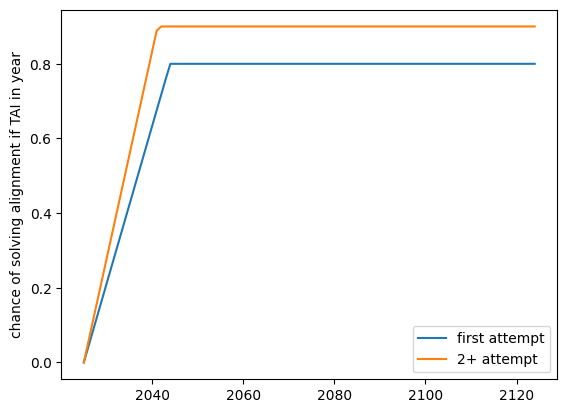

In [19]:
if years[-1] > 2200:
    years = list(range(VARS['CURRENT_YEAR'], 2200))

alignment_p = np.array([p_alignment_solved(year=y - VARS['CURRENT_YEAR'], first_attempt=True) for y in years])
alignment_p2 = np.array([p_alignment_solved(year=y - VARS['CURRENT_YEAR'], first_attempt=False) for y in years])
plt.plot(years, alignment_p, label='first attempt')
plt.plot(years, alignment_p2, label='2+ attempt')
plt.legend()
plt.ylabel('chance of solving alignment if TAI in year')
plt.show()


In [20]:
for y in list(years[:17]) + list(years[17::10]):
    str_ = 'Year: {} - chance of solving TAI alignment {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_p[y - VARS['CURRENT_YEAR']] * 100, 0),
                      round(alignment_p2[y - VARS['CURRENT_YEAR']] * 100, 0)))

Year: 2025 - chance of solving TAI alignment 0.0% (2nd attempt 0.0%)
Year: 2026 - chance of solving TAI alignment 4.0% (2nd attempt 6.0%)
Year: 2027 - chance of solving TAI alignment 8.0% (2nd attempt 11.0%)
Year: 2028 - chance of solving TAI alignment 13.0% (2nd attempt 17.0%)
Year: 2029 - chance of solving TAI alignment 17.0% (2nd attempt 22.0%)
Year: 2030 - chance of solving TAI alignment 21.0% (2nd attempt 28.0%)
Year: 2031 - chance of solving TAI alignment 25.0% (2nd attempt 33.0%)
Year: 2032 - chance of solving TAI alignment 30.0% (2nd attempt 39.0%)
Year: 2033 - chance of solving TAI alignment 34.0% (2nd attempt 44.0%)
Year: 2034 - chance of solving TAI alignment 38.0% (2nd attempt 50.0%)
Year: 2035 - chance of solving TAI alignment 42.0% (2nd attempt 56.0%)
Year: 2036 - chance of solving TAI alignment 46.0% (2nd attempt 61.0%)
Year: 2037 - chance of solving TAI alignment 51.0% (2nd attempt 67.0%)
Year: 2038 - chance of solving TAI alignment 55.0% (2nd attempt 72.0%)
Year: 2039 

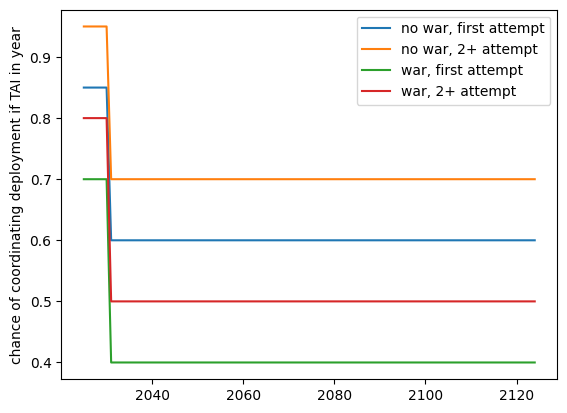

In [21]:
coordination_p = np.array([p_alignment_deployment_safety_and_coordination(year=y - VARS['CURRENT_YEAR'], war=False, variables=VARS, first_attempt=True) for y in years])
coordination_p2 = np.array([p_alignment_deployment_safety_and_coordination(year=y - VARS['CURRENT_YEAR'], war=False, variables=VARS, first_attempt=False) for y in years])
coordination_p_war = np.array([p_alignment_deployment_safety_and_coordination(year=y - VARS['CURRENT_YEAR'], war=True, variables=VARS, first_attempt=True) for y in years])
coordination_p2_war = np.array([p_alignment_deployment_safety_and_coordination(year=y - VARS['CURRENT_YEAR'], war=True, variables=VARS, first_attempt=False) for y in years])
plt.plot(years, coordination_p, label='no war, first attempt')
plt.plot(years, coordination_p2, label='no war, 2+ attempt')
plt.plot(years, coordination_p_war, label='war, first attempt')
plt.plot(years, coordination_p2_war, label='war, 2+ attempt')
plt.legend()
plt.ylabel('chance of coordinating deployment if TAI in year')
plt.show()


In [22]:
for y in list(years[:17]) + list(years[17::10]):
    str_ = 'Year: {} - chance of coordinating deployment no war -- {}% (2nd attempt {}%); war -- {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(coordination_p[y - VARS['CURRENT_YEAR']] * 100, 0),
                      round(coordination_p2[y - VARS['CURRENT_YEAR']] * 100, 0),
                      round(coordination_p_war[y - VARS['CURRENT_YEAR']] * 100, 0),
                      round(coordination_p2_war[y - VARS['CURRENT_YEAR']] * 100, 0)))

Year: 2025 - chance of coordinating deployment no war -- 85.0% (2nd attempt 95.0%); war -- 70.0% (2nd attempt 80.0%)
Year: 2026 - chance of coordinating deployment no war -- 85.0% (2nd attempt 95.0%); war -- 70.0% (2nd attempt 80.0%)
Year: 2027 - chance of coordinating deployment no war -- 85.0% (2nd attempt 95.0%); war -- 70.0% (2nd attempt 80.0%)
Year: 2028 - chance of coordinating deployment no war -- 85.0% (2nd attempt 95.0%); war -- 70.0% (2nd attempt 80.0%)
Year: 2029 - chance of coordinating deployment no war -- 85.0% (2nd attempt 95.0%); war -- 70.0% (2nd attempt 80.0%)
Year: 2030 - chance of coordinating deployment no war -- 85.0% (2nd attempt 95.0%); war -- 70.0% (2nd attempt 80.0%)
Year: 2031 - chance of coordinating deployment no war -- 60.0% (2nd attempt 70.0%); war -- 40.0% (2nd attempt 50.0%)
Year: 2032 - chance of coordinating deployment no war -- 60.0% (2nd attempt 70.0%); war -- 40.0% (2nd attempt 50.0%)
Year: 2033 - chance of coordinating deployment no war -- 60.0% (

In [23]:
print('AI X-Risk BY EOY year')

def find(y_c, category):
    return bayes.bayesnet(define_event_lambda,
                          find=lambda e: e['category'] == category and e['final_year'] <= y_c,
                          n=VARS['RUNS'])

target_years = [2025, 2026, 2027, 2028, 2030, 2035, 2040, 2050, 2060, 2070, 2100]
target_years = [y for y in target_years if y <= VARS['MAX_YEAR']]
for y_c in target_years:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse') + find(y_c, 'xrisk_tai_misuse_extinction')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


AI X-Risk BY EOY year
2025 - 0.0% (Extinction: 0.0%, Bad TAI singleton: 0.0%, Subtly misaligned singleton: 0.0%, Misuse singleton: 0.0%)
2026 - 0.5% (Extinction: 0.0%, Bad TAI singleton: 0.4%, Subtly misaligned singleton: 0.0%, Misuse singleton: 0.1%)
2027 - 1.6% (Extinction: 0.1%, Bad TAI singleton: 1.2%, Subtly misaligned singleton: 0.0%, Misuse singleton: 0.3%)
2028 - 4.7% (Extinction: 0.4%, Bad TAI singleton: 3.4%, Subtly misaligned singleton: 0.1%, Misuse singleton: 0.8%)
2030 - 13.7% (Extinction: 1.2%, Bad TAI singleton: 9.6%, Subtly misaligned singleton: 0.4%, Misuse singleton: 2.5%)
2035 - 25.0% (Extinction: 2.0%, Bad TAI singleton: 16.3%, Subtly misaligned singleton: 1.1%, Misuse singleton: 5.6%)
2040 - 29.1% (Extinction: 2.2%, Bad TAI singleton: 18.2%, Subtly misaligned singleton: 1.6%, Misuse singleton: 7.1%)
2050 - 32.3% (Extinction: 2.3%, Bad TAI singleton: 19.2%, Subtly misaligned singleton: 2.4%, Misuse singleton: 8.4%)
2060 - 34.2% (Extinction: 2.4%, Bad TAI singleton: 

In [24]:
print('Chance of successfully aligning TAI by EOY year')
for y_c in target_years:
    r = bayes.bayesnet(define_event_lambda,
                       find=lambda e: e['tai_type'] == 'aligned_agent' and e['tai_year'] <= y_c,
                       n=VARS['RUNS'])
    r1 = bayes.bayesnet(define_event_lambda,
                        find=lambda e: e['category'] == 'aligned_tai_ends_time_of_perils' and e['final_year'] <= y_c,
                        n=VARS['RUNS'])
    print('{} - {}% ({}% ends time of perils, {}% does not)'.format(y_c,
                                                                    round(r * 100, 2),
                                                                    round(r1 * 100, 2),
                                                                    round((r - r1) * 100, 2)))
    

Chance of successfully aligning TAI by EOY year
2025 - 0.0% (0.0% ends time of perils, 0.0% does not)
2026 - 0.03% (0.0% ends time of perils, 0.03% does not)
2027 - 0.22% (0.02% ends time of perils, 0.2% does not)
2028 - 0.95% (0.1% ends time of perils, 0.85% does not)
2030 - 4.28% (0.43% ends time of perils, 3.84% does not)
2035 - 11.75% (1.15% ends time of perils, 10.6% does not)
2040 - 16.83% (1.67% ends time of perils, 15.16% does not)
2050 - 24.31% (2.38% ends time of perils, 21.93% does not)
2060 - 29.45% (2.89% ends time of perils, 26.56% does not)
2070 - 32.94% (3.24% ends time of perils, 29.7% does not)
2100 - 37.6% (3.73% ends time of perils, 33.87% does not)


In [25]:
print('Cumulative Total X-Risk (including non-extinction x-risks and "ok but not great" x-risks)')

def find_xrisk(y_c, category):
    return bayes.bayesnet(define_event_lambda,
                          find=lambda e: 'xrisk' in e['category'] and category in e['category'] and e['final_year'] <= y_c,
                          n=VARS['RUNS'])

for y_c in target_years:
    ai = find_xrisk(y_c, 'tai')
    nukes = find_xrisk(y_c, 'nukes')
    unknown = find_xrisk(y_c, 'unknown')
    nano = find_xrisk(y_c, 'nanotech')
    natural = find_xrisk(y_c, 'supervolcano')
    bio = find_xrisk(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Unknown unknown: {}%)'
    print(out.format(y_c,
                     round((ai + nukes + bio + nano + unknown) * 100, 2),
                     round(ai * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))

print('-')
print('AI risk is {}% of total risk'.format(round(ai / (ai + nukes + bio + nano + unknown) * 100, 2)))
print('AI risk is {}% of known risk'.format(round(ai / (ai + nukes + bio + nano) * 100, 2)))

Cumulative Total X-Risk (including non-extinction x-risks and "ok but not great" x-risks)
2025 - 0.0% (AI: 0.0%, Nukes: 0.001%, Bio: 0.001%, Nano: 0.0%, Natural: 0.0%, Unknown unknown: 0.0%)
2026 - 0.52% (AI: 0.51%, Nukes: 0.011%, Bio: 0.002%, Nano: 0.0%, Natural: 0.0%, Unknown unknown: 0.002%)
2027 - 1.79% (AI: 1.76%, Nukes: 0.022%, Bio: 0.003%, Nano: 0.0%, Natural: 0.0%, Unknown unknown: 0.002%)
2028 - 5.18% (AI: 5.14%, Nukes: 0.033%, Bio: 0.004%, Nano: 0.0%, Natural: 0.0%, Unknown unknown: 0.003%)
2030 - 14.77% (AI: 14.7%, Nukes: 0.058%, Bio: 0.004%, Nano: 0.0%, Natural: 0.0%, Unknown unknown: 0.006%)
2035 - 26.92% (AI: 26.79%, Nukes: 0.116%, Bio: 0.005%, Nano: 0.001%, Natural: 0.0%, Unknown unknown: 0.008%)
2040 - 31.32% (AI: 31.16%, Nukes: 0.148%, Bio: 0.007%, Nano: 0.001%, Natural: 0.0%, Unknown unknown: 0.014%)
2050 - 34.65% (AI: 34.43%, Nukes: 0.191%, Bio: 0.011%, Nano: 0.002%, Natural: 0.0%, Unknown unknown: 0.019%)
2060 - 36.61% (AI: 36.35%, Nukes: 0.219%, Bio: 0.011%, Nano: 

In [26]:
print('Cumulative Total Extinction Risk')

for y_c in target_years:
    ai = find(y_c, 'xrisk_full_unaligned_tai_extinction') + find(y_c, 'xrisk_tai_misuse_extinction')
    nukes_war = find(y_c, 'xrisk_nukes_war')
    nukes_accident = find(y_c, 'xrisk_nukes_accident')
    unknown = find(y_c, 'xrisk_unknown_unknown')
    bio_war = find(y_c, 'xrisk_bio_war')
    bio_accident = find(y_c, 'xrisk_bio_accident')
    bio_nonstate = find(y_c, 'xrisk_bio_nonstate')
    nanotech = find(y_c, 'xrisk_nanotech')
    supervolcano = find(y_c, 'xrisk_supervolcano')
    
    r = bayes.bayesnet(define_event_lambda,
                       find=lambda e: e['category'] in extinctions and e['final_year'] <= y_c,
                       n=VARS['RUNS'])
    
    out = '{} - {}% (AI: {}%, Nukes: {}% (War: {}% Accident: {}%), Bio: {}% (War: {}%, Accident: {}%, Nonstate: {}%), Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round(r * 100, 2),
                     round(ai * 100, 2),
                     round((nukes_war + nukes_accident) * 100, 3),
                     round(nukes_war * 100, 3),
                     round(nukes_accident * 100, 3),
                     round((bio_war + bio_accident + bio_nonstate) * 100, 3),
                     round(bio_war * 100, 3),
                     round(bio_accident * 100, 3),
                     round(bio_nonstate * 100, 3),
                     round(nanotech * 100, 3),
                     round(supervolcano * 100, 3),
                     round(unknown * 100, 3)))
        

Cumulative Total Extinction Risk
2025 - 0.0% (AI: 0.0%, Nukes: 0.001% (War: 0.001% Accident: 0.0%), Bio: 0.001% (War: 0.0%, Accident: 0.0%, Nonstate: 0.001%), Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2026 - 0.05% (AI: 0.04%, Nukes: 0.011% (War: 0.008% Accident: 0.003%), Bio: 0.002% (War: 0.0%, Accident: 0.001%, Nonstate: 0.001%), Nano: 0.0%, Natural: 0.0%, Other: 0.002%)
2027 - 0.18% (AI: 0.15%, Nukes: 0.022% (War: 0.019% Accident: 0.003%), Bio: 0.003% (War: 0.0%, Accident: 0.002%, Nonstate: 0.001%), Nano: 0.0%, Natural: 0.0%, Other: 0.002%)
2028 - 0.48% (AI: 0.44%, Nukes: 0.033% (War: 0.028% Accident: 0.005%), Bio: 0.004% (War: 0.0%, Accident: 0.003%, Nonstate: 0.001%), Nano: 0.0%, Natural: 0.0%, Other: 0.003%)
2030 - 1.41% (AI: 1.34%, Nukes: 0.058% (War: 0.043% Accident: 0.015%), Bio: 0.004% (War: 0.0%, Accident: 0.003%, Nonstate: 0.001%), Nano: 0.0%, Natural: 0.0%, Other: 0.006%)
2035 - 2.42% (AI: 2.28%, Nukes: 0.116% (War: 0.088% Accident: 0.028%), Bio: 0.005% (War: 0.0%, Accident: 

In [27]:
Counter(bayes.bayesnet(define_event_lambda, find=lambda e: e['category'], raw=True, n=VARS['RUNS']))

Counter({'aligned_tai_does_not_end_time_of_perils': 34284,
         'boring': 21838,
         'xrisk_full_unaligned_tai_singleton': 20735,
         'xrisk_tai_misuse': 9604,
         'xrisk_subtly_unaligned_tai': 3809,
         'aligned_tai_ends_time_of_perils': 3796,
         'xrisk_full_unaligned_tai_extinction': 2480,
         'xrisk_full_unaligned_but_morally_good_tai_singleton': 2300,
         'xrisk_tai_misuse_extinction': 571,
         'xrisk_nukes_war': 273,
         'xrisk_nukes_accident': 131,
         'xrisk_unknown_unknown': 100,
         'xrisk_nanotech': 51,
         'xrisk_bio_nonstate': 17,
         'xrisk_bio_accident': 11})

In [28]:
# https://www.metaculus.com/questions/1493/global-population-decline-10-by-2100/
print('Cumulative Total Catastrophe Risk (defined as 10%+ death)')

for y_c in target_years:
    r = bayes.bayesnet(define_event_lambda,
                       find=lambda e: (len(e['catastrophe']) > 0 and e['catastrophe'][0]['year'] <= y_c) or (e['category'] in extinctions and e['final_year'] <= y_c),
                       n=VARS['RUNS'])
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

Cumulative Total Catastrophe Risk (defined as 10%+ death)
2025 - 0.14%
2026 - 0.95%
2027 - 2.56%
2028 - 6.42%
2030 - 16.95%
2035 - 30.46%
2040 - 35.51%
2050 - 39.47%
2060 - 41.99%
2070 - 43.83%
2100 - 47.68%


In [29]:
print('Cumulative Total *Actively Bad* Future X-Risk (including non-extinction risks but excluding subtle AI misalignment)')

for y_c in target_years:
    ai = find_xrisk(y_c, 'tai')
    ai_subtle_misalignment = find_xrisk(y_c, 'xrisk_subtly_unaligned_tai')
    nukes = find_xrisk(y_c, 'nukes')
    unknown = find_xrisk(y_c, 'unknown')
    nano = find_xrisk(y_c, 'nanotech')
    natural = find_xrisk(y_c, 'supervolcano')
    bio = find_xrisk(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai - ai_subtle_misalignment + nukes + bio + nano + unknown) * 100, 2),
                     round((ai - ai_subtle_misalignment) * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))

print('-')
print('AI risk is {}% of total risk'.format(round((ai - ai_subtle_misalignment) / ((ai - ai_subtle_misalignment) + nukes + bio + nano + unknown) * 100, 2)))
print('AI risk is {}% of known risk'.format(round((ai - ai_subtle_misalignment) / ((ai - ai_subtle_misalignment) + nukes + bio + nano) * 100, 2)))

Cumulative Total *Actively Bad* Future X-Risk (including non-extinction risks but excluding subtle AI misalignment)
2025 - 0.0% (AI: 0.0%, Nukes: 0.001%, Bio: 0.001%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2026 - 0.52% (AI: 0.5%, Nukes: 0.011%, Bio: 0.002%, Nano: 0.0%, Natural: 0.0%, Other: 0.002%)
2027 - 1.77% (AI: 1.74%, Nukes: 0.022%, Bio: 0.003%, Nano: 0.0%, Natural: 0.0%, Other: 0.002%)
2028 - 5.08% (AI: 5.04%, Nukes: 0.033%, Bio: 0.004%, Nano: 0.0%, Natural: 0.0%, Other: 0.003%)
2030 - 14.36% (AI: 14.29%, Nukes: 0.058%, Bio: 0.004%, Nano: 0.0%, Natural: 0.0%, Other: 0.006%)
2035 - 25.78% (AI: 25.65%, Nukes: 0.116%, Bio: 0.005%, Nano: 0.001%, Natural: 0.0%, Other: 0.008%)
2040 - 29.67% (AI: 29.5%, Nukes: 0.148%, Bio: 0.007%, Nano: 0.001%, Natural: 0.0%, Other: 0.014%)
2050 - 32.23% (AI: 32.01%, Nukes: 0.191%, Bio: 0.011%, Nano: 0.002%, Natural: 0.0%, Other: 0.019%)
2060 - 33.66% (AI: 33.4%, Nukes: 0.219%, Bio: 0.011%, Nano: 0.003%, Natural: 0.0%, Other: 0.027%)
2070 - 34.62% (AI:

In [30]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2025-04-02 14:58:07.025692


## Appendix

In [31]:
def print_states(collectors, y_c):
    states = [c['category'] if (not isinstance(c['final_year'], str) and c['final_year'] <= y_c) else 'boring' for c in collectors]
    c = Counter(states)
    c = dict([(k, round(v / VARS['RUNS'] * 100, 3)) for k, v in c.items()])
    for k in c.keys():
        if k not in FUTURES:
            raise ValueError('Future {} not in `FUTURES`'.format(k))
    for state in FUTURES:
        if not c.get(state):
            c[state] = 0.0
    return sorted(c.items(), key=lambda x: x[1], reverse=True)


print('Detail on World State At Year')
for y_c in target_years:
    print('## {} ##'.format(y_c)) 
    pprint(print_states(collectors, y_c))
    print('-')
    print('-')

Detail on World State At Year
## 2025 ##
[('boring', 99.998),
 ('xrisk_nukes_war', 0.001),
 ('xrisk_bio_nonstate', 0.001),
 ('xrisk_full_unaligned_tai_extinction', 0.0),
 ('xrisk_tai_misuse_extinction', 0.0),
 ('xrisk_nukes_accident', 0.0),
 ('xrisk_unknown_unknown', 0.0),
 ('xrisk_nanotech', 0.0),
 ('xrisk_bio_accident', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_supervolcano', 0.0),
 ('xrisk_full_unaligned_tai_extinction_but_its_morally_good_actually', 0.0),
 ('xrisk_tai_misuse_extinction_but_its_morally_good_actually', 0.0),
 ('xrisk_nukes_war_but_its_morally_good_actually', 0.0),
 ('xrisk_nukes_accident_but_its_morally_good_actually', 0.0),
 ('xrisk_unknown_unknown_but_its_morally_good_actually', 0.0),
 ('xrisk_nanotech_but_its_morally_good_actually', 0.0),
 ('xrisk_bio_accident_but_its_morally_good_actually', 0.0),
 ('xrisk_bio_war_but_its_morally_good_actually', 0.0),
 ('xrisk_bio_nonstate_but_its_morally_good_actually', 0.0),
 ('xrisk_supervolcano_but_its_morally_good_actually', 0.

In [32]:
print('Detail on Catastrophe States At Year')

def print_catastrophe(collectors, y_c):
    catastrophes = [[('', 0)] if len(cs['catastrophe']) == 0 else [(c['catastrophe'], c['year']) for c in cs['catastrophe']] for cs in collectors]
    catastrophes = [c  if c[0][1] <= y_c else '' for c in catastrophes]
    c = Counter([' '.join(sorted([c[0] for c in cs])) for cs in catastrophes])
    c = dict([(k, round(v / VARS['RUNS'] * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in target_years:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe(collectors, y_c))
    print('-')
    print('-')

Detail on Catastrophe States At Year
## 2025 ##
[('', 99.86)]
-
-
## 2026 ##
[('', 99.07), ('xrisk_full_unaligned_tai_singleton', 0.4)]
-
-
## 2027 ##
[('', 97.49),
 ('xrisk_full_unaligned_tai_singleton', 1.33),
 ('xrisk_tai_misuse', 0.26),
 ('nukes_war', 0.16),
 ('xrisk_full_unaligned_tai_extinction', 0.13),
 ('engineered_pathogen', 0.12),
 ('natural_pathogen', 0.1)]
-
-
## 2028 ##
[('', 93.65),
 ('xrisk_full_unaligned_tai_singleton', 3.82),
 ('xrisk_tai_misuse', 0.76),
 ('xrisk_full_unaligned_tai_extinction', 0.4),
 ('averting_misaligned_tai', 0.26),
 ('nukes_war', 0.24),
 ('engineered_pathogen', 0.15),
 ('natural_pathogen', 0.14)]
-
-
## 2030 ##
[('', 83.26),
 ('xrisk_full_unaligned_tai_singleton', 10.58),
 ('xrisk_tai_misuse', 2.33),
 ('xrisk_full_unaligned_tai_extinction', 1.19),
 ('averting_misaligned_tai', 0.72),
 ('nukes_war', 0.42),
 ('engineered_pathogen', 0.24),
 ('natural_pathogen', 0.19),
 ('nukes_accident', 0.15),
 ('averting_intentional_tai', 0.15)]
-
-
## 2035 ##
[('', 

In [33]:
print('Detail on *First* Catastrophe State At Year')

def print_catastrophe_first(collectors, y_c):
    catastrophes = [[('', 0)] if len(cs['catastrophe']) == 0 else [(c['catastrophe'], c['year']) for c in cs['catastrophe']] for cs in collectors]
    c = Counter([c[0][0] if c[0][1] <= y_c else '' for c in catastrophes])
    c = dict([(k, round(v / VARS['RUNS'] * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in target_years:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe_first(collectors, y_c))
    print('-')
    print('-')

Detail on *First* Catastrophe State At Year
## 2025 ##
[('', 99.86)]
-
-
## 2026 ##
[('', 99.07),
 ('xrisk_full_unaligned_tai_singleton', 0.4),
 ('nukes_war', 0.14),
 ('engineered_pathogen', 0.12),
 ('natural_pathogen', 0.11)]
-
-
## 2027 ##
[('', 97.49),
 ('xrisk_full_unaligned_tai_singleton', 1.33),
 ('xrisk_tai_misuse', 0.26),
 ('nukes_war', 0.25),
 ('engineered_pathogen', 0.18),
 ('natural_pathogen', 0.16),
 ('xrisk_full_unaligned_tai_extinction', 0.13),
 ('averting_misaligned_tai', 0.11)]
-
-
## 2028 ##
[('', 93.65),
 ('xrisk_full_unaligned_tai_singleton', 3.82),
 ('xrisk_tai_misuse', 0.76),
 ('xrisk_full_unaligned_tai_extinction', 0.4),
 ('nukes_war', 0.38),
 ('averting_misaligned_tai', 0.32),
 ('engineered_pathogen', 0.25),
 ('natural_pathogen', 0.21),
 ('nukes_accident', 0.13)]
-
-
## 2030 ##
[('', 83.26),
 ('xrisk_full_unaligned_tai_singleton', 10.58),
 ('xrisk_tai_misuse', 2.33),
 ('xrisk_full_unaligned_tai_extinction', 1.19),
 ('averting_misaligned_tai', 0.86),
 ('nukes_war'

In [34]:
print('Detail on # of Catastrophes At Year')

for y_c in target_years:
    print('## # of catastrophes as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len([c for c in cs['catastrophe'] if c['year'] <= y_c]) for cs in collectors]))
    print('-')
    print('-')

Detail on # of Catastrophes At Year
## # of catastrophes as of 2025 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 0.0,
 99: 0.0}
-
-
## # of catastrophes as of 2026 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 0.0,
 99: 0.0}
-
-
## # of catastrophes as of 2027 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 0.0,
 99: 1.0}
-
-
## # of catastrophes as of 2028 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 1.0,
 99: 1.0}
-
-
## # of catastrophes as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of catastrophes as of 2035 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 1.0,
 80: 1

In [35]:
print('Detail on Double Catastrophe X-Risks')

def print_double_catastrophes(catastrophes):
    c = Counter(['' if c is None else c for c in catastrophes])
    c = dict([(k, round(v / VARS['RUNS'] * 100, 3)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    # c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in target_years:
    print('## {} ##'.format(y_c))  
    pprint(print_double_catastrophes(['' if (not isinstance(c['final_year'], str) and c['final_year'] > y_c) else c['double_catastrophe_xrisk'] for c in collectors]))
    print('-')
    print('-')

Detail on Double Catastrophe X-Risks
## 2025 ##
[('', 100.0)]
-
-
## 2026 ##
[('', 100.0)]
-
-
## 2027 ##
[('', 100.0)]
-
-
## 2028 ##
[('', 100.0)]
-
-
## 2030 ##
[('', 100.0)]
-
-
## 2035 ##
[('', 100.0)]
-
-
## 2040 ##
[('', 100.0)]
-
-
## 2050 ##
[('', 100.0)]
-
-
## 2060 ##
[('', 100.0)]
-
-
## 2070 ##
[('', 100.0)]
-
-
## 2100 ##
[('', 100.0)]
-
-


In [36]:
trigger_found = False
i = 0
y_range = list(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR']))
trigger_found = False
while not trigger_found and i < len(y_range):
    print('.', end='')
    y_c = y_range[i]
    ai = find_xrisk(y_c, 'tai')
    nukes = find_xrisk(y_c, 'nukes')
    unknown = find_xrisk(y_c, 'unknown')
    nano = find_xrisk(y_c, 'nanotech')
    natural = find_xrisk(y_c, 'supervolcano')
    bio = find_xrisk(y_c, 'bio')
    xrisk = ai + nukes + bio + nano + unknown
    if xrisk > 0.05:
        trigger_found = True
        y_c -= (xrisk - 0.05)/0.05
    i += 1

print('')
if not trigger_found:
    y_c = '>{}'.format(VARS['MAX_YEAR'])
else:
    y_c = dt.strftime(dt.now() + timedelta(days=(y_c - 2023) * 365.24), '%Y %b %d')
    
print('5% X-Risk By {}'.format(y_c))

....
5% X-Risk By 2030 Mar 20


In [37]:
print('Total X-Risk IN THAT SPECIFIC YEAR (non-cumulative) (including non-extinction x-risks)')

print('1/6: AI')
ai = np.diff(np.array([find_xrisk(y, 'tai') for y in tqdm(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR']))]))
print('2/6: Nukes')
nukes = np.diff(np.array([find_xrisk(y, 'nukes') for y in tqdm(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR']))]))
print('3/6: Unknown')
unknown = np.diff(np.array([find_xrisk(y, 'unknown') for y in tqdm(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR']))]))
print('4/6: Nanotech')
nano = np.diff(np.array([find_xrisk(y, 'nanotech') for y in tqdm(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR']))]))
print('5/6: Natural risk')
natural = np.diff(np.array([find_xrisk(y, 'supervolcano') for y in tqdm(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR']))]))
print('6/6: Biorisk')
bio = np.diff(np.array([find_xrisk(y, 'bio') for y in tqdm(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR']))]))

xrisk_df = pd.DataFrame({'year': range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR'] - 1),
                         'ai': ai,
                         'nukes': nukes,
                         'unknown': unknown,
                         'nano': nano,
                         'natural': natural,
                         'bio': bio})
xrisk_df['total'] = xrisk_df['ai'] + xrisk_df['nukes'] + xrisk_df['unknown'] + xrisk_df['nano'] + xrisk_df['natural'] + xrisk_df['bio']
xrisk_df.to_csv('caches/xrisk_df.csv', index=False)
xrisk_df

Total X-Risk IN THAT SPECIFIC YEAR (non-cumulative) (including non-extinction x-risks)
1/6: AI


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.81it/s]


2/6: Nukes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.46it/s]


3/6: Unknown


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.59it/s]


4/6: Nanotech


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.29it/s]


5/6: Natural risk


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.70it/s]


6/6: Biorisk


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.34it/s]


,year,ai,nukes,unknown,nano,natural,bio,total
0,2025,0.00506,0.00010,0.00002,0.00000,0.0,0.00001,0.00519
1,2026,0.01254,0.00011,0.00000,0.00000,0.0,0.00001,0.01266
2,2027,0.03377,0.00011,0.00001,0.00000,0.0,0.00001,0.03390
3,2028,0.05079,0.00011,0.00001,0.00000,0.0,0.00000,0.05091
4,2029,0.04486,0.00014,0.00002,0.00000,0.0,0.00000,0.04502
...,...,...,...,...,...,...,...,...
94,2119,0.00002,0.00002,0.00000,0.00006,0.0,0.00000,0.00010
95,2120,0.00001,0.00002,0.00000,0.00001,0.0,0.00001,0.00005
96,2121,0.00008,0.00000,0.00001,0.00002,0.0,0.00000,0.00011
97,2122,0.00015,0.00003,0.00000,0.00000,0.0,0.00000,0.00018


In [38]:
all_states = []
for y_c in tqdm(range(VARS['CURRENT_YEAR'], VARS['MAX_YEAR'] - 1)):
    state = dict([s for s in print_states(collectors, y_c) if 'morally_good_actually' not in s[0]])
    state['year'] = y_c
    all_states.append(state)

world_states_df = pd.DataFrame(all_states)
world_states_df.to_csv('caches/world_states_df.csv', index=False)
world_states_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:02<00:00, 44.87it/s]


,boring,xrisk_nukes_war,xrisk_bio_nonstate,xrisk_full_unaligned_tai_extinction,xrisk_tai_misuse_extinction,xrisk_nukes_accident,xrisk_unknown_unknown,xrisk_nanotech,xrisk_bio_accident,xrisk_bio_war,xrisk_supervolcano,xrisk_tai_misuse,aligned_tai,aligned_tai_ends_time_of_perils,aligned_tai_does_not_end_time_of_perils,xrisk_full_unaligned_tai_singleton,xrisk_full_unaligned_but_morally_good_tai_singleton,xrisk_subtly_unaligned_tai,year
0,99.998,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,2025
1,99.476,0.008,0.001,0.033,0.006,0.003,0.002,0.000,0.001,0.0,0.0,0.067,0.0,0.003,0.000,0.355,0.041,0.004,2026
2,98.191,0.019,0.001,0.130,0.020,0.003,0.002,0.000,0.002,0.0,0.0,0.262,0.0,0.022,0.000,1.208,0.121,0.019,2027
3,94.722,0.028,0.001,0.403,0.042,0.005,0.003,0.000,0.003,0.0,0.0,0.765,0.0,0.101,0.000,3.438,0.390,0.099,2028
4,89.487,0.034,0.001,0.819,0.096,0.010,0.004,0.000,0.003,0.0,0.0,1.569,0.0,0.245,0.000,6.707,0.770,0.255,2029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,56.196,0.262,0.016,2.479,0.571,0.130,0.097,0.039,0.011,0.0,0.0,9.591,0.0,3.784,0.003,20.722,2.299,3.800,2119
95,56.186,0.264,0.016,2.479,0.571,0.130,0.097,0.045,0.011,0.0,0.0,9.592,0.0,3.784,0.003,20.723,2.299,3.800,2120
96,56.180,0.266,0.017,2.479,0.571,0.130,0.097,0.046,0.011,0.0,0.0,9.592,0.0,3.785,0.003,20.723,2.299,3.801,2121
97,56.167,0.266,0.017,2.479,0.571,0.130,0.098,0.048,0.011,0.0,0.0,9.594,0.0,3.787,0.003,20.728,2.299,3.802,2122


In [39]:
print('Total X-Risk OR catastrophe by EOY year')

for y_c in target_years:
    r = bayes.bayesnet(define_event_lambda,
                       find=lambda e: ('xrisk' in e['category'] and e['final_year'] <= y_c) or (len(e['catastrophe']) > 0 and e['catastrophe'][0]['year'] <= y_c),
                       n=VARS['RUNS'])
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


Total X-Risk OR catastrophe by EOY year
2025 - 0.14%
2026 - 0.96%
2027 - 2.57%
2028 - 6.52%
2030 - 17.36%
2035 - 31.59%
2040 - 37.13%
2050 - 41.81%
2060 - 44.83%
2070 - 46.96%
2100 - 51.19%


In [40]:
print('Total X-Risk AND catastrophe by EOY year')

for y_c in target_years:
    r = bayes.bayesnet(define_event_lambda,
                       find=lambda e: ('xrisk' in e['category'] and e['final_year'] <= y_c) and (len(e['catastrophe']) > 0 and e['catastrophe'][0]['year'] <= y_c),
                       n=VARS['RUNS'])
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


Total X-Risk AND catastrophe by EOY year
2025 - 0.0%
2026 - 0.5%
2027 - 1.73%
2028 - 5.0%
2030 - 14.15%
2035 - 25.36%
2040 - 29.19%
2050 - 31.7%
2060 - 33.11%
2070 - 34.07%
2100 - 35.4%


In [41]:
# https://forum.effectivealtruism.org/posts/nYgw4FNpHf9bmJGEi/forecasting-thread-how-does-ai-risk-level-vary-based-on

def generate_conditional(y_low, y_high):
    def fn(e):
        if e['tai_year'] is None:
            return False
        elif e['tai_year'] < y_low:
            return False
        elif e['tai_year'] > y_high:
            return False
        else:
            return True
    return fn
    

def find(y_low, y_high, category):
    try:
        return bayes.bayesnet(define_event_lambda,
                              find=lambda e: e['category'] == category and e['final_year'] <= (VARS['MAX_YEAR'] - 1 if y_high >= VARS['MAX_YEAR'] else y_high),
                              conditional_on=generate_conditional(y_low, y_high),
                              n=VARS['RUNS'])
    except ValueError:
        return 0


for y_c in [[2022, 2029], [2029, 2039], [2039, 2059], [2059, VARS['MAX_YEAR'] - 1], [2022, 2070]]:
    print('AI X-Risk conditional on TAI beween beginning of {} and end of {}'.format(y_c[0] + 1, y_c[1]))
    extinction = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c[0], y_c[1], 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c[0], y_c[1], 'xrisk_tai_misuse')
    out = '{}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))
    print('-')


AI X-Risk conditional on TAI beween beginning of 2023 and end of 2029
60.9% (Extinction: 5.3%, Bad TAI singleton: 43.7%, Subtly misaligned singleton: 1.7%, Misuse singleton: 10.2%)
-
AI X-Risk conditional on TAI beween beginning of 2030 and end of 2039
55.2% (Extinction: 4.2%, Bad TAI singleton: 34.1%, Subtly misaligned singleton: 3.5%, Misuse singleton: 13.4%)
-
AI X-Risk conditional on TAI beween beginning of 2040 and end of 2059
28.4% (Extinction: 1.1%, Bad TAI singleton: 9.7%, Subtly misaligned singleton: 6.8%, Misuse singleton: 10.8%)
-
AI X-Risk conditional on TAI beween beginning of 2060 and end of 2124
23.9% (Extinction: 0.8%, Bad TAI singleton: 7.8%, Subtly misaligned singleton: 7.0%, Misuse singleton: 8.4%)
-
AI X-Risk conditional on TAI beween beginning of 2023 and end of 2070
46.1% (Extinction: 3.2%, Bad TAI singleton: 26.7%, Subtly misaligned singleton: 4.4%, Misuse singleton: 11.9%)
-


In [42]:
print('Have we seen the following wars by EOY year?')

def print_wars(wars, y_c):
    bs = [[w['belligerents'] for w in ws if w != [] and w['start_year'] <= y_c] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / VARS['RUNS'] * 100, 3)) for k, v in bs.items()])
    bs = sorted(bs.items(), key=lambda x: x[1], reverse=True)
    for war in ['US/China', 'US/Russia', 'Other']:
        print('{}: {}%'.format(war, round(sum([b[1] if war in b[0] else 0 for b in bs]), 1)))

for y_c in target_years:
    print('## {} ##'.format(y_c))  
    print_wars([c['wars'] for c in collectors], y_c)
    print('-')
    print('-')

Have we seen the following wars by EOY year?
## 2025 ##
US/China: 0.8%
US/Russia: 2.1%
Other: 0.0%
-
-
## 2026 ##
US/China: 7.5%
US/Russia: 3.8%
Other: 0.1%
-
-
## 2027 ##
US/China: 13.3%
US/Russia: 4.0%
Other: 0.1%
-
-
## 2028 ##
US/China: 18.7%
US/Russia: 4.3%
Other: 0.2%
-
-
## 2030 ##
US/China: 25.6%
US/Russia: 4.7%
Other: 0.2%
-
-
## 2035 ##
US/China: 32.7%
US/Russia: 5.4%
Other: 0.4%
-
-
## 2040 ##
US/China: 33.5%
US/Russia: 6.0%
Other: 0.5%
-
-
## 2050 ##
US/China: 34.9%
US/Russia: 7.1%
Other: 1.6%
-
-
## 2060 ##
US/China: 36.2%
US/Russia: 8.1%
Other: 2.8%
-
-
## 2070 ##
US/China: 37.3%
US/Russia: 9.1%
Other: 3.9%
-
-
## 2100 ##
US/China: 40.2%
US/Russia: 12.1%
Other: 7.1%
-
-


In [43]:
print('Offensive nuclear weapon use (1+ fatality) by EOY year?')

def p_nuke_used_by(y_c):
    return bayes.bayesnet(define_event_lambda,
                          find=lambda e: len(e['nuclear_weapon_used']) > 0 and e['nuclear_weapon_used'][0] <= y_c,
                          n=VARS['RUNS'])

for y_c in target_years:
    print('{}: {}%'.format(y_c, round(p_nuke_used_by(y_c) * 100, 2)))

Offensive nuclear weapon use (1+ fatality) by EOY year?
2025: 3.33%
2026: 4.06%
2027: 4.87%
2028: 5.77%
2030: 7.66%
2035: 11.67%
2040: 14.31%
2050: 17.84%
2060: 20.42%
2070: 22.78%
2100: 28.4%


In [44]:
print('Detail on war states')

def print_wars(wars, y_c):
    bs = [[w['belligerents'] for w in ws if w != [] and w['start_year'] <= y_c] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / VARS['RUNS'] * 100, 3)) for k, v in bs.items()])
    return sorted(bs.items(), key=lambda x: x[1], reverse=True)

for y_c in target_years:
    print('## {} ##'.format(y_c))  
    pprint(print_wars([c['wars'] for c in collectors], y_c))
    print('-')
    print('-')

Detail on war states
## 2025 ##
[('', 97.098), ('US/Russia', 2.061), ('US/China', 0.799), ('Other', 0.042)]
-
-
## 2026 ##
[('', 88.665), ('US/China', 7.474), ('US/Russia', 3.766), ('Other', 0.095)]
-
-
## 2027 ##
[('', 82.528),
 ('US/China', 13.311),
 ('US/Russia', 4.016),
 ('Other', 0.143),
 ('US/China US/China', 0.001),
 ('US/China US/Russia', 0.001)]
-
-
## 2028 ##
[('', 76.901),
 ('US/China', 18.65),
 ('US/Russia', 4.243),
 ('Other', 0.175),
 ('US/China US/Russia', 0.016),
 ('US/China US/China', 0.015)]
-
-
## 2030 ##
[('', 69.53),
 ('US/China', 25.454),
 ('US/Russia', 4.612),
 ('Other', 0.234),
 ('US/China US/China', 0.116),
 ('US/China US/Russia', 0.052),
 ('Other US/Russia', 0.001),
 ('Other US/China', 0.001)]
-
-
## 2035 ##
[('', 61.766),
 ('US/China', 31.706),
 ('US/Russia', 5.212),
 ('US/China US/China', 0.773),
 ('Other', 0.348),
 ('US/China US/Russia', 0.178),
 ('Other US/China', 0.009),
 ('US/China US/China US/China', 0.003),
 ('US/Russia US/Russia', 0.002),
 ('US/China U

In [45]:
print('Detail on # of Wars At Year')

for y_c in target_years:
    print('## # of wars as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len([c for c in cs['wars'] if c['start_year'] <= y_c]) for cs in collectors]))
    print('-')
    print('-')


Detail on # of Wars At Year
## # of wars as of 2025 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 0.0,
 99: 1.0}
-
-
## # of wars as of 2026 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of 2027 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of 2028 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of 2035 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of

In [46]:
print('Detail on War Length States At Year')

def print_wars(wars, y_c):
    bs = [[(w['end_year'] - w['start_year'] if w['end_year'] < y_c else y - w['start_year']) if w != [] and w['start_year'] <= y_c else 0 for w in ws] for ws in wars]
    bs = [round(sum(b) / (y - VARS['CURRENT_YEAR']) * 100, 1) for b in bs]
    return bs

for y_c in target_years:
    print('## Percent of time in war as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles(print_wars([c['wars'] for c in collectors], y_c)))
    print('-')
    print('-')

Detail on War Length States At Year
## Percent of time in war as of 2025 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 0.0,
 99: 100.0}
-
-
## Percent of time in war as of 2026 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 99.0,
 95: 99.0,
 99: 100.0}
-
-
## Percent of time in war as of 2027 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 99.0,
 95: 99.0,
 99: 100.0}
-
-
## Percent of time in war as of 2028 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 96.9,
 90: 99.0,
 95: 99.0,
 99: 100.0}
-
-
## Percent of time in war as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 1.0,
 80: 96.9,
 90: 97.9,
 95: 99.0,
 99: 100.0}
-
-
## Percent of time in war as of 2035 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0

In [47]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2025-04-02 14:58:29.038281
